In [14]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import time, coordinates as coord, units as u

import arviz as az
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import corner

from lightkurve.search import search_lightcurve
import lightkurve

from astropy.time import Time
import astropy.units as u
import astropy.constants as c
from astropy.io import fits
from astropy.table import Table

import time as timer
tangerine= np.load('/Users/arcticfox/parula_colors.npy')[np.linspace(0,180,5,dtype=int)]

In [2]:
def normalize_lc(flux):
    #Returns median-normalized flux in units of parts-per-thousand
    mu = np.nanmedian(flux)
    return (flux/mu - 1) * 1e3

def open_spoc(filename):
    hdu = fits.open(filename)
    m = ((np.isfinite(hdu[1].data['TIME'])==True) & 
         (hdu[1].data['QUALITY']==0) &
         (np.isfinite(hdu[1].data['SAP_FLUX'])==True))
    lk = lightkurve.lightcurve.LightCurve(time=hdu[1].data['TIME'][m]+0.0,
                                          time_format='btjd',
                                           flux=hdu[1].data['SAP_FLUX'][m],
                                          flux_err=hdu[1].data['SAP_FLUX_ERR'][m]).normalize()
    lk.flux = (lk.flux-1)*1e3
    lk.flux_err = lk.flux_err*1e3
    lk.time = lk.time-2454833+2457000
    binned = lk.bin(time_bin_size=10*u.min)
    return lk, binned

In [3]:
path = '/Users/arcticfox/Documents/v1298tau/tess/light_curves/'
fn43 = 'tess2021258175143-s0043-0000000015756231-0214-s_lc.fits'
_,lk_43 = open_spoc(os.path.join(path,fn43))
fn44 = 'tess2021284114741-s0044-0000000015756231-0215-s_lc.fits'
_,lk_44 = open_spoc(os.path.join(path,fn44))

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

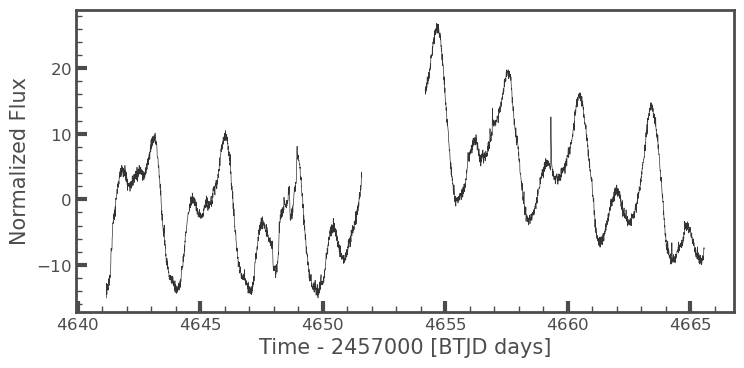

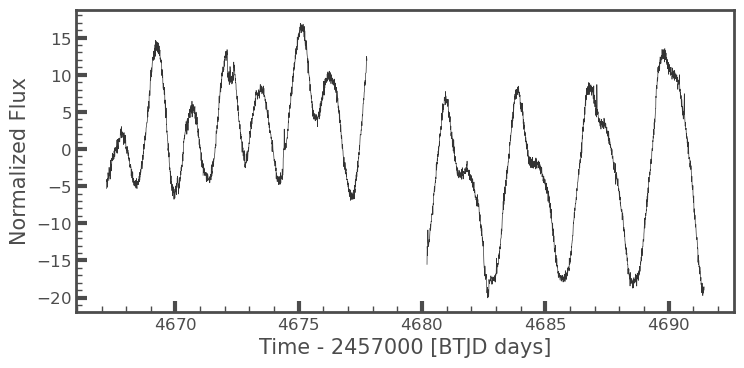

In [4]:
lk_43.plot();lk_44.plot()

In [5]:
x = np.ascontiguousarray(np.append(lk_43.time.value,lk_44.time.value))
y = np.ascontiguousarray(np.append(lk_43.flux.value,lk_44.flux.value))
yerr = np.ascontiguousarray(np.append(lk_43.flux_err.value,lk_44.flux_err.value))


# **TESS TICA light curve v2** 

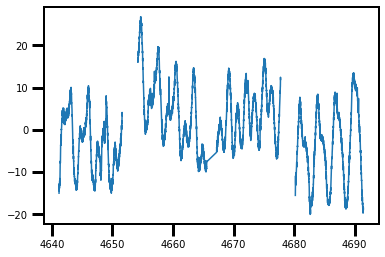

In [6]:
plt.plot(x,y)
tess_texp = np.median(np.diff(x))
#plt.plot(temp1[:,0],temp1[:,1])

In [16]:
tab = Table.read('/Users/arcticfox/Documents/v1298tau/tess/ttvs.csv',format='csv')

In [52]:
#Stellar parameters
M_star  = 1.10, 0.05
R_star  = 1.305, 0.07

include_planet_e = True

if include_planet_e == True:    
    
    #Livingston ephemeris
    t0s     = np.array([2231.281202 - 0.75*4.66/24, 
                              2239.400529 + 0.5*5.59/24, 
                              2234.046461 - 0.5*6.42/24, 
                              2263.6229, 4644.08])
    tess_t0s = np.array([4689.399860318306,
                         4682.6055129254755,
                         4648.09023,
                         4648.79668])
    periods = np.array([8.249147, 12.401369,  24.141445, 36.695032307689445])    

    rors    = np.array([0.0381, 0.0436, 0.0636, 0.0664])
    depths  = np.array(1e3*(rors**2))
    t14s    = np.array([4.66, 5.59, 6.42, 7.45])/24.0

elif include_planet_e == False:
    t0s     = np.array([2231.281202, 2239.400529, 2234.046461])# - x_ref
    periods = np.array([8.249147, 12.401369,  24.141445])
    rors    = np.array([0.0381, 0.0436, 0.0700])
    depths  = np.array(1e3*(rors**2))    

# Number of planets to be included in fit
n_pl = len(t0s)

# Compute the expected transit times for a linear ephemeris
expected_transit_times = xo.orbits.ttv.compute_expected_transit_times(
    x.min(), x.max()+100, periods, tess_t0s,
)

### Before we start fitting the light curve let's see if we can identify the transits by eye

In [53]:
x.min(),x.max()

(4641.172949466202, 4691.447271297837)

In [54]:
Time(expected_transit_times[2],format='bkjd').datetime#.to('datetime')

array([datetime.datetime(2021, 9, 23, 14, 9, 55, 872000),
       datetime.datetime(2021, 10, 17, 17, 33, 36, 720000),
       datetime.datetime(2021, 11, 10, 20, 57, 17, 568000),
       datetime.datetime(2021, 12, 5, 0, 20, 58, 416000),
       datetime.datetime(2021, 12, 29, 3, 44, 39, 264000),
       datetime.datetime(2022, 1, 22, 7, 8, 20, 112000)], dtype=object)

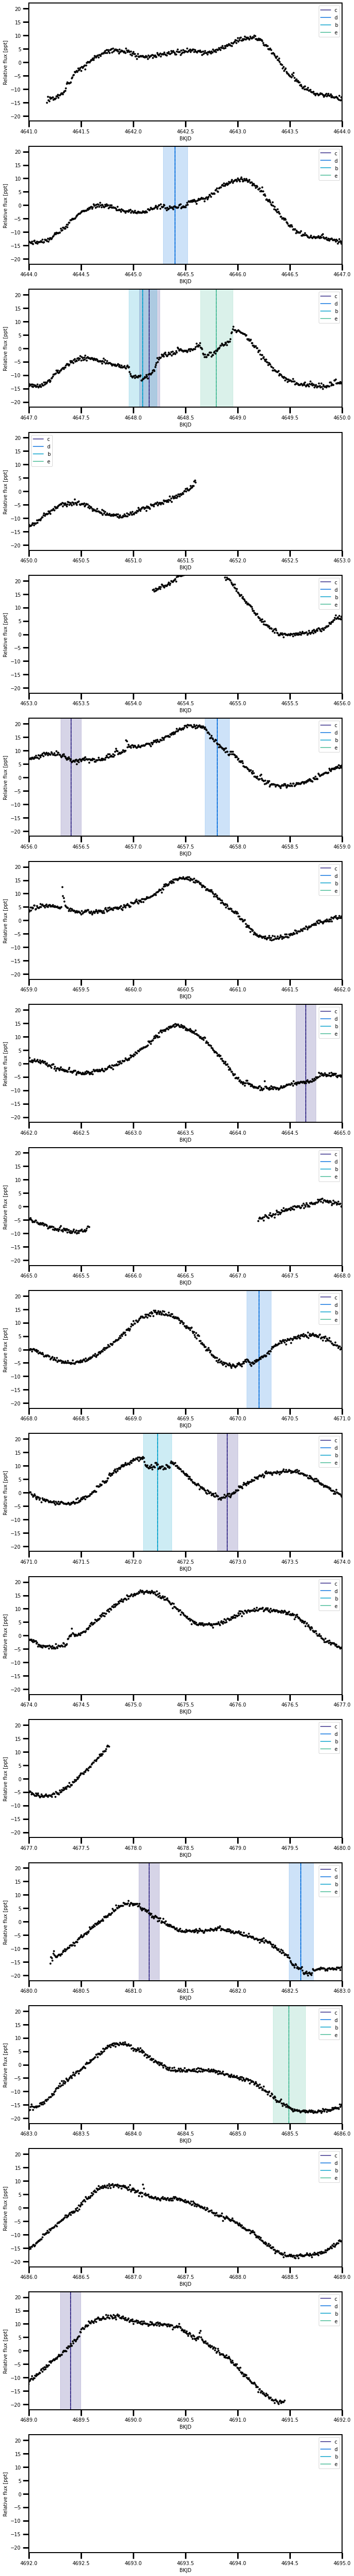

In [55]:
nrows = 18
xmin = int(x.min()) + 3*np.arange(nrows)

fig,axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10,4*nrows))

for n in range(nrows):
    ax = axes[n]

    for i,let in enumerate("cdbe"):
        ttimes = expected_transit_times[i]
        for j,_tt in enumerate(ttimes):
            if (_tt>x.min()) & (_tt<x.max()):
                ax.axvline(_tt, color=tangerine[i], label=let)
                ax.axvspan(_tt-0.5*t14s[i], _tt+0.5*t14s[i], 
                           alpha=0.2, color=tangerine[i])
                ax.axvline(_tt, color=tangerine[i], ls='--') # planet c

   # ax.errorbar(lk.time.value, binned.flux.value,
   #             yerr=binned.flux_err.value, marker='.', linestyle='')
    ax.plot(x, y, 'k.')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())


    ax.set_xlim(xmin[n], xmin[n]+3)
    ax.set_ylim(-22,22)
    ax.set_xlabel("BKJD")
    ax.set_ylabel("Relative flux [ppt]")

plt.tight_layout()
plt.show()

It looks like: 

1. Planet d arrives late at BKJD = 4645.4
2. Planet b arrives early at BKJD = 4648.1
3. Planet c arrives late at BKJD = 4648.53? There is a dip right before the ingress of planet e, with seemingly the right duration. It's hard to tell for sure because the noise changes significantly around the transit.
4. Planet e transits around BKJD = 4648.8 


The data beyond BKJD = 4651.5 are corrupted so let's remove it.

# **The SimpleTransitOrbit model** (fitting in terms of duration)


In [9]:
ett = np.array([expected_transit_times[0][0],
               expected_transit_times[1][0],
               expected_transit_times[2][0],
                expected_transit_times[3][0],
               ])
ett

array([4648.135648  , 4645.38257333, 4648.057211  , 4648.8       ])

<ErrorbarContainer object of 3 artists>

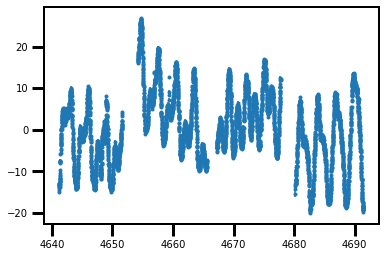

In [10]:
periods   = np.array([8.249147, 12.401369,  24.141445, 48.0])    
t0s       = np.round(ett,2)+0.0# #np.array([4648.14, 4645.4, 4648.1, 4648.8])
rors      = np.array([0.0381, 0.0436, 0.0700, 0.0611])
depths    = np.array(1e3*(rors**2))
durations = np.array([4.66, 5.59, 6.42, 7.45])/24.0
n_pl      = len(periods)
R_star    = 1.305, 0.07

#x = tica2_bkjd
#y = tica2_f1

m = (np.isfinite(x)) & (np.isfinite(y))# & (x<4651.5)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)

# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)

plt.errorbar(x,y,yerr=yerr, marker='.', linestyle='')

In [11]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)

# Required changes:
# We can have different depths for K2 and TESS


def build_model(mask=None, 
                start=None,
                ttvs=False,
                eccentric=False):
    
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    with pm.Model() as model:

        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])        
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1, shape=n_pl)
        
        #log_depth_tess = pm.Normal("log_depth_tess", mu=np.log(depths), sigma=2.0, shape=n_pl)                
        log_depth_tess = pm.Normal("log_depth_tess", mu=np.log(depths), 
                                   sigma=0.1, shape=n_pl)                        
        ror_tess = pm.Deterministic("ror_tess", 
                                    star.get_ror_from_approx_transit_depth(
                                        1e-3 * tt.exp(log_depth_tess), b
                                    ),
                                   )
                    
        r_pl_tess = pm.Deterministic("r_pl_tess", ror_tess * r_star)
        r_pl_rade = pm.Deterministic("r_pl_rade", ror_tess * r_star * c.R_sun/c.R_earth)

        ecc = np.zeros(n_pl)
        omega = np.pi/2*np.ones(n_pl)

            
        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=n_pl)
        log_period = pm.Normal("log_period", mu=np.log(periods), sd=1, shape=n_pl)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Orbit models
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        ########################################################################################        
        ########################################################################################
        # Compute the model light curve
        mean_tess = pm.Normal("mean_tess", mu=0.0, sd=10.0)
        
        # Quadratic trend for varying background flux
        trend = pm.Normal(
            "trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3
        )
        # Define the background model
        A = np.vander(x, 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))        
        
        light_curves_tess = (
            star.get_light_curve(
                orbit=orbit, 
                r=r_pl_tess, 
                t=x[mask], 
                texp=tess_texp) * 1e3
        )
        light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) + mean_tess
        resid_tess = y[mask] - light_curve_tess - bkg[mask]

        # Transit jitter & GP parameters
        log_sigma_lc_tess  = pm.Normal("log_sigma_lc_tess", mu=np.log(0.01*np.std(yerr[mask])), sd=10)
        log_sigma_jit_tess = pm.Normal("log_sigma_jit_tess", mu=np.log(0.02*np.std(yerr[mask])), sd=10) 
        yerr_tess = pm.Deterministic("yerr_tess",
                                     tt.exp(log_sigma_lc_tess) + tt.exp(2*log_sigma_jit_tess)*(light_curve_tess**2))
        #yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess))
                
        #The parameters of the RotationTerm kernel
        sigma_rot_tess = pm.InverseGamma(
            "sigma_rot_tess", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period_rot_tess = pm.Normal("log_period_rot_tess", mu=np.log(2.87), sigma=2.0)
        period_rot_tess = pm.Deterministic("period_rot_tess", tt.exp(log_period_rot_tess))
        log_Q0_rot_tess = pm.HalfNormal("log_Q0_rot_tess", sigma=2.0)
        log_dQ_rot_tess = pm.Normal("log_dQ_rot_tess", mu=0.0, sigma=2.0)
        f_rot_tess = pm.Uniform("f_rot_tess", lower=0.1, upper=1.0)

        kernel_tess = terms.RotationTerm(
                    sigma=sigma_rot_tess,
                    period=period_rot_tess,
                    Q0=tt.exp(log_Q0_rot_tess),
                    dQ=tt.exp(log_dQ_rot_tess),
                    f=f_rot_tess,
                )

        gp_tess = GaussianProcess(kernel_tess, t=x[mask], yerr=yerr_tess)
        gp_tess.marginal("transit_obs_tess", observed=resid_tess)        

        #Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * tt.stack(
                [
                    star.get_light_curve(
                        orbit=orbit, r=r_pl_tess, t=t0[n] + phase_lc, texp=tess_texp
                    )[..., n]
                    for n in range(n_pl)
                ],
                axis=-1,
            ),
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        
        map_soln = pmx.optimize(start=start, 
                                vars=trend)
        
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[b,
                                      log_depth_tess])
        
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[sigma_rot_tess,
                                      log_period_rot_tess,
                                      log_Q0_rot_tess,
                                      log_dQ_rot_tess,
                                      f_rot_tess,
                                      mean_tess,
                                      ]
                               )
        
        
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves_tess", 
                 "gp_pred_tess"],
                pmx.eval_in_model([light_curves_tess,
                                   gp_tess.predict(resid_tess)], map_soln),
            )
        )

    return model, map_soln, extras, orbit

model0, map_soln0, extras0, orbit0 = build_model(ttvs=True)

optimizing logp for variables: [trend]


message: Desired error not necessarily achieved due to precision loss.
logp: -605905594.5474435 -> -605905211.1494417
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -605905211.1494417 -> -603760120.3115857
optimizing logp for variables: [log_depth_tess, b]


message: Desired error not necessarily achieved due to precision loss.
logp: -603760120.3115857 -> -603517542.1948867
optimizing logp for variables: [mean_tess, f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess]


message: Desired error not necessarily achieved due to precision loss.
logp: -603517542.1948867 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess, log_sigma_jit_tess, log_sigma_lc_tess, trend, mean_tess, log_period, t0, log_depth_tess, b, u_star, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -603517542.1948867 -> -1246642.4029906099


In [12]:
map_soln0['yerr_tess']

array([5.18887583e-10, 5.18887583e-10, 5.18887583e-10, ...,
       5.18887583e-10, 5.18887583e-10, 5.18887583e-10])

In [16]:
np.nanstd(x)

14.933287753595666

<ErrorbarContainer object of 3 artists>

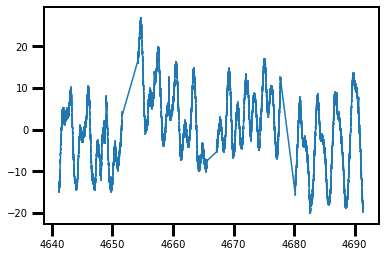

In [17]:
yerr_tess = np.ascontiguousarray(map_soln0['yerr_tess'] + 0.0, dtype=np.float64)
np.random.seed(123)
yerr_tess = np.ascontiguousarray(np.random.normal(np.nanmedian(lk_43.flux_err.value),
                                                  np.nanstd(lk_43.flux_err.value), len(x)),
                                 dtype=np.float64)
plt.errorbar(x,y,yerr=yerr_tess)

In [18]:
def depth_duration_model(ttvs=False):

    with pm.Model() as model:

        # Physical parameters that will be sampled
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])  
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        b = pm.Uniform("b", lower=0, upper=1, shape=n_pl)
        #t0 = pm.Normal("t0", mu=t0s, sigma=0.1, shape=n_pl)
        
        #log_period = pm.Normal("log_period", mu=np.log(periods), 
        #                       sigma=0.1, shape=n_pl)
        
        
        log_depth = pm.Normal("log_depth", mu=np.log(depths), 
                              sigma=0.1, shape=n_pl)
        log_duration = pm.Normal("log_duration", mu=np.log(durations), 
                                 sigma=0.1, shape=n_pl)

        # Track parameters of interest as deterministics
        duration = pm.Deterministic("duration", tt.exp(log_duration))
        ror = pm.Deterministic("ror", 
                                    star.get_ror_from_approx_transit_depth(
                                        1e-3 * tt.exp(log_depth), b
                                    ),
                                    )
        r_pl_tess = pm.Deterministic("r_pl_tess", ror * r_star)
        r_pl_rade = pm.Deterministic("r_pl_rade", ror * r_star * c.R_sun/c.R_earth)  
        
        ecc = np.zeros(n_pl)
        omega = np.pi/2*np.ones(n_pl)

        if ttvs==True:
            # Now we have a parameter for each transit time of each planet:
            transit_times = []
            for i in range(n_pl):
                transit_times.append(
                    pm.Normal(
                        "tts_{0}".format(i),
                        mu=expected_transit_times[i],
                        sd=0.1, #Change this back to 0.1 to work
                        shape=len(expected_transit_times[i]),
                    )
                )

            # Set up an orbit for the planets
            orbit = xo.orbits.TTVOrbit(
                r_star=r_star,
                m_star=m_star,
                b=b,
                ecc=ecc,
                omega=omega,
                transit_times=transit_times)

            # It will be useful later to track some parameters of the orbit
            t0 = pm.Deterministic("t0", orbit.t0)
            period = pm.Deterministic("period", orbit.period)
            log_period = pm.Normal("log_period", mu=np.log(periods), 
                               sigma=0.1, shape=n_pl)
            for i in range(n_pl):
                pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])
            #period = pm.Deterministic("period", tt.exp(log_period))
            
        elif ttvs==False:
            
            # Orbital parameters for the planets
            t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=n_pl)
            log_period = pm.Normal("log_period", mu=np.log(periods), sd=1, shape=n_pl)
            period = pm.Deterministic("period", tt.exp(log_period))

            # Orbit models
            orbit = xo.orbits.KeplerianOrbit(
                r_star=r_star,
                m_star=m_star,
                period=period,
                t0=t0,
                b=b,
                ecc=ecc,
                omega=omega,
            )


        # Quadratic trend for varying background flux
        trend = pm.Normal(
            "trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3
        )
        # Define the background model
        A = np.vander(x, 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))     
        
        #Compute the light curve model
        mean_tess = pm.Normal("mean_tess", mu=0.0, sd=10.0)
        
        light_curves_tess = (
            star.get_light_curve(
                orbit=orbit, 
                r=r_pl_tess, 
                t=x, 
                texp=tess_texp) * 1e3
        )
        light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) + mean_tess
        resid_tess = y - light_curve_tess - bkg
        
        # Transit jitter & GP parameters
        log_sigma_lc_tess  = pm.Normal("log_sigma_lc_tess", mu=np.log(0.01*np.std(y)), 
                                       sd=5)
        log_sigma_jit_tess = pm.Normal("log_sigma_jit_tess", mu=np.log(0.02*np.std(y)), 
                                       sd=5) 
        #yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess) + tt.exp(2*log_sigma_jit_tess)*(light_curve_tess**2))
        #yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess))
                
        #The parameters of the RotationTerm kernel
        sigma_rot_tess = pm.InverseGamma(
            "sigma_rot_tess", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period_rot_tess = pm.Normal("log_period_rot_tess", mu=np.log(2.87), sigma=2.0)
        period_rot_tess = pm.Deterministic("period_rot_tess", tt.exp(log_period_rot_tess))
        log_Q0_rot_tess = pm.HalfNormal("log_Q0_rot_tess", sigma=2.0)
        log_dQ_rot_tess = pm.Normal("log_dQ_rot_tess", mu=0.0, sigma=2.0)
        f_rot_tess = pm.Uniform("f_rot_tess", lower=0.1, upper=1.0)

        kernel_tess = terms.RotationTerm(
                    sigma=sigma_rot_tess,
                    period=period_rot_tess,
                    Q0=tt.exp(log_Q0_rot_tess),
                    dQ=tt.exp(log_dQ_rot_tess),
                    f=f_rot_tess,
                )

        gp = GaussianProcess(kernel_tess, t=x, yerr=yerr_tess)
        gp.marginal("transit_obs", observed=resid_tess)  


        # Compute and save the phased light curve models
        if ttvs == False:
            pm.Deterministic(
                "lc_pred_tess",
                1e3
                * tt.stack(
                    [
                        star.get_light_curve(
                            orbit=orbit, r=r_pl_tess, t=t0[n] + phase_lc, 
                            texp=tess_texp
                        )[..., n]
                        for n in range(n_pl)
                    ],
                    axis=-1,
                ),
            )  

        # Perform optimization
        start = model.test_point
        map_soln = pmx.optimize(start=start, 
                                vars=trend)
        
        if ttvs==True:
            map_soln = pmx.optimize(start=map_soln, vars=transit_times)
        elif ttvs==False:
            map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[b,
                                      log_depth])
        if ttvs == True:
            map_soln = pmx.optimize(start=map_soln, vars=transit_times)
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[sigma_rot_tess,
                                      log_period_rot_tess,
                                      log_Q0_rot_tess,
                                      log_dQ_rot_tess,
                                      f_rot_tess,
                                      mean_tess,
                                      ]
                               )
        
        
        map_soln = pmx.optimize(start=map_soln)

        # Package the MAP light curve and GP prediction
        extras = dict(
            zip(
                ["light_curves_tess", 
                  "gp_pred_tess"],
                pmx.eval_in_model([light_curves_tess,
                                    gp.predict(resid_tess)], map_soln),
            )
        )

    return model, map_soln, extras, orbit


model1, map_soln1, extras1, orbit1 = depth_duration_model(ttvs=False)

optimizing logp for variables: [trend]


message: Desired error not necessarily achieved due to precision loss.
logp: -9421.343949642689 -> -9389.676176671454
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -9389.676176671454 -> -8832.292007290713
optimizing logp for variables: [log_depth, b]


message: Optimization terminated successfully.
logp: -8832.292007290713 -> -8576.228676203098
optimizing logp for variables: [mean_tess, f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess]


message: Desired error not necessarily achieved due to precision loss.
logp: -8576.228676203098 -> -5720.637683738254
optimizing logp for variables: [f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess, log_sigma_jit_tess, log_sigma_lc_tess, mean_tess, trend, log_period, t0, log_duration, log_depth, b, u_star, m_star, r_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -5720.637683738254 -> -5654.446084066733


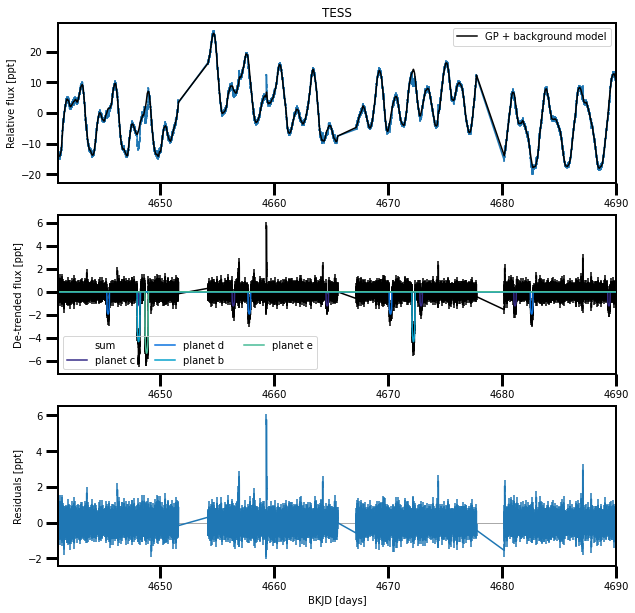

In [22]:
def plot_light_curve(soln, extras, xrange=[4641,4690], mask=None):


    if mask is None:
        mask = np.ones(len(x), dtype=bool)
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

        
    ax = axes[0]
    ax.errorbar(x[mask], y[mask], yerr=yerr_tess)#soln["yerr_tess"])
    gp_mod = extras["gp_pred_tess"] + soln["mean_tess"] + soln["bkg"]
    ax.plot(x[mask], gp_mod, color="k", label="GP + background model", zorder=4)
    ax.legend(fontsize=10, ncol=2)
    ax.set_ylabel("Relative flux [ppt]")
    
    ax.set_title('TESS')

    ax = axes[1]
    ax.errorbar(x[mask], y[mask] - gp_mod, yerr=yerr_tess,color='k')#soln["yerr_tess"])

    mod_sum = np.sum(extras["light_curves_tess"], axis=-1)
    ax.plot(x[mask], mod_sum, label="sum", color="w")
    
    for i, l in enumerate("cdbe"):
        mod = extras["light_curves_tess"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l), zorder=3,
                color=tangerine[i])
        
    
        
    ax.legend(fontsize=10, loc=3, ncol=3)
    ax.set_ylabel("De-trended flux [ppt]")
    

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves_tess"], axis=-1)
    ax.errorbar(x[mask], y[mask] - mod, yerr=yerr_tess)#soln["yerr_tess"])
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("Residuals [ppt]")
    ax.set_xlabel("BKJD [days]")
    
    for i in range(3):
        axes[i].set_xlim(xrange[0],xrange[1])
    

    return fig, gp_mod

_ = plot_light_curve(map_soln1, extras1)

In [23]:
with model1:
    trace_ex = pmx.sample(tune=500,
                          draws=5000,
                          start=map_soln1,
                          chains=3,
                          return_inferencedata=True,
                          random_seed=[39248934, 48374109, 84738013])
trace_ex.to_dataframe().to_csv('summary_2min.csv')

Multiprocess sampling (3 chains in 4 jobs)
NUTS: [f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess, log_sigma_jit_tess, log_sigma_lc_tess, mean_tess, trend, log_period, t0, log_duration, log_depth, b, u_star, m_star, r_star]


Sampling 3 chains for 500 tune and 5_000 draw iterations (1_500 + 15_000 draws total) took 15202 seconds.
There were 4430 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3989 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9769522959370647, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 4933 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [24]:
flat_samps = trace_ex.posterior

In [25]:
key = 't0'
rnd = 5
for j in range(0,4):
    med = np.nanmedian(flat_samps[key][:,:,j].data)
    upp = np.nanpercentile(flat_samps[key][:,:,j].data,84)
    low = np.nanpercentile(flat_samps[key][:,:,j].data, 16)
    u = np.round(upp-med,rnd)
    l = np.round(med-low,rnd)
    m = np.round(med, rnd)
    print('$' + str(m)+'_{-'+str(l)+'}^{+'+str(u)+'}$')

$4648.16636_{-0.00339}^{+0.00269}$
$4645.41494_{-0.00157}^{+0.00172}$
$4648.09023_{-0.00132}^{+0.00129}$
$4648.79668_{-0.00114}^{+0.00121}$


In [26]:
k2_t0=[ 2231.2797, 2239.3913, 2234.0488]
k2_per=[ 8.24958, 12.4032, 24.1396]

In [ ]:
for i in range(len(k2_t0)):
    predicted = k2_t0[i]+k2_per[i]*np.arange(2,350)
    new = np.nanmedian(flat_samps[key][:,:,i].data)
    diff = np.abs(predicted - new)
    print(predicted[np.argmin(diff)], new)
    print(((predicted[np.argmin(diff)] - new) * units.day).to(units.hour))

In [27]:
from astropy import units

In [28]:
key = 'r_pl_rade'
rnd = 2
for j in range(0,4):
    med = np.nanmedian(flat_samps[key][:,:,j].data)*units.Rearth
    upp = np.nanpercentile(flat_samps[key][:,:,j].data,84)*units.Rearth
    low = np.nanpercentile(flat_samps[key][:,:,j].data, 16)*units.Rearth
    u = np.round(upp.to(units.Rjup).value-med.to(units.Rjup).value,rnd)
    l = np.round(med.to(units.Rjup).value-low.to(units.Rjup).value,rnd)
    m = np.round(med.to(units.Rjup).value, rnd)
    print('$' + str(m)+'_{-'+str(l)+'}^{+'+str(u)+'}$')

$0.42_{-0.02}^{+0.02}$
$0.55_{-0.03}^{+0.02}$
$0.83_{-0.03}^{+0.03}$
$0.94_{-0.04}^{+0.04}$


In [29]:
gpdict = {}
gpdict['time'] = x
gpdict['flux'] = y
gpdict['flux_err'] = yerr_tess
gpdict['gp_mod'] = extras1["gp_pred_tess"] + map_soln1["mean_tess"] + map_soln1["bkg"]
letter =['c','d','b','e']
for i in range(4):
    print(len(extras0['light_curves_tess'][i]))
    gpdict['planet_{}'.format(letter[i])] = extras1['light_curves_tess'][i]

4
4
4
4


In [30]:
np.save('/Users/arcticfox/Documents/v1298tau/tess/model_2min.npy', model1)
np.save('/Users/arcticfox/Documents/v1298tau/tess/map_soln_2min.npy', map_soln1)
np.save('/Users/arcticfox/Documents/v1298tau/tess/extras_2min.npy', extras1)
np.save('/Users/arcticfox/Documents/v1298tau/tess/gp_2min.npy', gpdict)

In [31]:
((1.16*units.Mjup) / (4.0/3.0 * np.pi * (0.89*units.Rjup)**3)).to(units.g/units.cm**3)

<Quantity 2.04057113 g / cm3>

In [32]:
((0.64*units.Mjup) / (4.0/3.0 * np.pi * (0.85*units.Rjup)**3)).to(units.g/units.cm**3)

<Quantity 1.29237029 g / cm3>

In [33]:
map_soln1['ror']

array([0.03201342, 0.04095066, 0.06261472, 0.07099571])

## Accounting for TTVs

In [34]:
model2, map_soln2, extras2, orbit2 = depth_duration_model(ttvs=True)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -9491.84768369558 -> -9461.479443623884
optimizing logp for variables: [tts_3, tts_2, tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -9461.479443623884 -> -8846.002167312376
optimizing logp for variables: [log_depth, b]


message: Optimization terminated successfully.
logp: -8846.002167312376 -> -8761.755245891274
optimizing logp for variables: [tts_3, tts_2, tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -8761.755245891274 -> -8752.486740235667
optimizing logp for variables: [mean_tess, f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess]


message: Desired error not necessarily achieved due to precision loss.
logp: -8752.486740235667 -> -5702.977151545326
optimizing logp for variables: [f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess, log_sigma_jit_tess, log_sigma_lc_tess, mean_tess, trend, log_period, tts_3, tts_2, tts_1, tts_0, log_duration, log_depth, b, u_star, m_star, r_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -5702.977151545326 -> -5651.294529902729


In [35]:
with model2:
    trace_ex_ttvs = pmx.sample(tune=500,
                          draws=5000,
                          start=map_soln2,
                          chains=3,
                          return_inferencedata=True,
                          random_seed=[39248934, 48374109, 84738013])
trace_ex_ttvs.to_dataframe().to_csv('summary_2min_ttvs.csv')

Multiprocess sampling (3 chains in 4 jobs)
NUTS: [f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess, log_sigma_jit_tess, log_sigma_lc_tess, mean_tess, trend, log_period, tts_3, tts_2, tts_1, tts_0, log_duration, log_depth, b, u_star, m_star, r_star]


Sampling 3 chains for 500 tune and 5_000 draw iterations (1_500 + 15_000 draws total) took 2049 seconds.
The acceptance probability does not match the target. It is 0.011199139426227366, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.0026755899992985375, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9999999627731814, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [36]:
flat_samps_ttvs = trace_ex_ttvs.posterior

In [37]:
from astropy.table import Table, Column

$-22.565533_{-0.097049}^{+0.212955}$
$11.765382_{-0.119092}^{+0.098012}$
$41.438755_{-0.512391}^{+0.15775}$
$-12.582641_{-0.01138}^{+0.003889}$
$-33.299266_{-0.082463}^{+0.409579}$
$15.238492_{-0.093951}^{+0.048616}$
$-4.166919_{-0.054142}^{+0.113885}$
$4.408926_{-0.284293}^{+0.05196}$
$3.741412_{-0.058506}^{+0.168426}$
$-3.981231_{-0.000205}^{+0.056318}$
$0.0_{-0.0}^{+0.0}$
$0.0_{-0.0}^{+0.0}$


(4643.0, 4693.0)

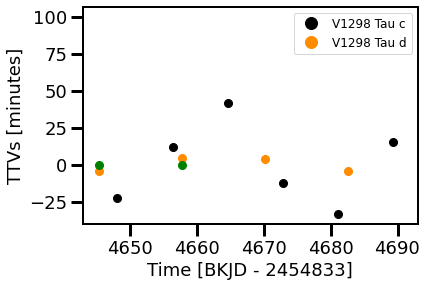

In [57]:
plt.rcParams['font.size']=18
key = 'ttvs_0'
rnd = 6

tab = Table(names=['planet','expected_transit_time', 'tts',
                   'ttvs_med', 'ttvs_l16', 'ttvs_u84'],
            dtype=[str,float,float,float,float,float])

for j in range(flat_samps_ttvs[key].shape[-1]):
    med = np.nanmedian(flat_samps_ttvs[key][:,:,j].data)*units.day
    upp = np.nanpercentile(flat_samps_ttvs[key][:,:,j].data,84)*units.day
    low = np.nanpercentile(flat_samps_ttvs[key][:,:,j].data, 16)*units.day
    u = np.round((upp-med).to(units.min).value,rnd)
    l = np.round((med-low).to(units.min).value,rnd)
    m = np.round(med.to(units.min).value, rnd)
    print('$' + str(m)+'_{-'+str(l)+'}^{+'+str(u)+'}$')
    tab.add_row(['c', 
                 map_soln2['t0'][0]+map_soln2['period'][0]*j, 
                 map_soln2['tts_0'][j], m, l, u])
    
    plt.errorbar(map_soln2['t0'][0]+map_soln2['period'][0]*j,
                 m, yerr=np.nanmedian([u,l]), marker='o', color='k',ms=8)
    
key = 'ttvs_1'
rnd = 6
for j in range(flat_samps_ttvs[key].shape[-1]):
    med = np.nanmedian(flat_samps_ttvs[key][:,:,j].data)*units.day
    upp = np.nanpercentile(flat_samps_ttvs[key][:,:,j].data,84)*units.day
    low = np.nanpercentile(flat_samps_ttvs[key][:,:,j].data, 16)*units.day
    u = np.round((upp-med).to(units.min).value,rnd)
    l = np.round((med-low).to(units.min).value,rnd)
    m = np.round(med.to(units.min).value, rnd)
    print('$' + str(m)+'_{-'+str(l)+'}^{+'+str(u)+'}$')
    tab.add_row(['d', 
                 map_soln2['t0'][1]+map_soln2['period'][1]*j, 
                 map_soln2['tts_1'][j], m, l, u])
    
    plt.errorbar(map_soln2['t0'][1]+map_soln2['period'][1]*j,
                 m, yerr=np.nanmedian([u,l]), marker='o', 
                 color='darkorange',ms=8)
    
key = 'ttvs_2'
rnd = 6
for j in range(flat_samps_ttvs[key].shape[-1]):
    med = np.nanmedian(flat_samps_ttvs[key][:,:,j].data)*units.day
    upp = np.nanpercentile(flat_samps_ttvs[key][:,:,j].data,84)*units.day
    low = np.nanpercentile(flat_samps_ttvs[key][:,:,j].data, 16)*units.day
    u = np.round((upp-med).to(units.min).value,rnd)
    l = np.round((med-low).to(units.min).value,rnd)
    m = np.round(med.to(units.min).value, rnd)
    print('$' + str(m)+'_{-'+str(l)+'}^{+'+str(u)+'}$')
    tab.add_row(['b', 
                 map_soln2['t0'][1]+map_soln2['period'][1]*j, 
                 map_soln2['tts_1'][j], m, l, u])
    
    plt.errorbar(map_soln2['t0'][1]+map_soln2['period'][1]*j,
                 m, yerr=np.nanmedian([u,l]), marker='o', 
                 color='green',ms=8)   
    
    
plt.xlabel('Time [BKJD - 2454833]')

plt.plot(100,100,'ko',label='V1298 Tau c')
plt.plot(100,100,'o',color='darkorange',label='V1298 Tau d')
plt.legend(fontsize=12)

plt.ylabel('TTVs [minutes]')
plt.xlim(4643,4693)
#plt.ylim(-20,20)
#plt.savefig('ttvs.png',dpi=250,rasterize=True,bbox_inches='tight')

In [64]:
np.nanmedian(tab[tab['planet']=='d']['ttvs_med']), np.nanstd(tab[tab['planet']=='d']['ttvs_med'])

(-0.11990950000000011, 4.081978847884503)

In [60]:
tab

planet,expected_transit_time,tts,ttvs_med,ttvs_l16,ttvs_u84
str1,float64,float64,float64,float64,float64
c,4648.173009344651,4648.157284464366,-22.565533,0.097049,0.212955
c,4656.416269730402,4656.424455992973,11.765382,0.119092,0.098012
c,4664.6595301161515,4664.688314778819,41.438755,0.512391,0.15775
c,4672.902790501902,4672.894110954918,-12.582641,0.01138,0.003889
c,4681.146050887653,4681.1229353447825,-33.299266,0.082463,0.409579
c,4689.389311273402,4689.399860318306,15.238492,0.093951,0.048616
d,4645.415139057293,4645.412232814333,-4.166919,0.054142,0.113885
d,4657.812843211454,4657.815917103081,4.408926,0.284293,0.05196
d,4670.210547365613,4670.213118311247,3.741412,0.058506,0.168426


In [39]:
tab.write('ttvs.csv',format='csv')

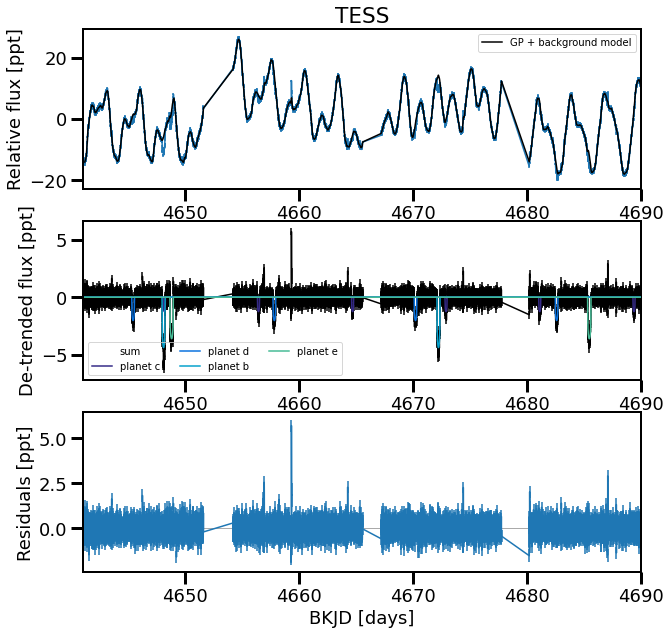

In [40]:
_, gp_mod = plot_light_curve(map_soln2, extras2)

In [42]:
lc_tab = Table()
lc_tab.add_column(Column(x,'time'))
lc_tab.add_column(Column(y,'flux'))
lc_tab.add_column(Column(yerr_tess,'flux_err'))
lc_tab.add_column(Column(gp_mod,
                         'gp_pred_tess'))
lc_tab.write('lc.csv',format='csv')

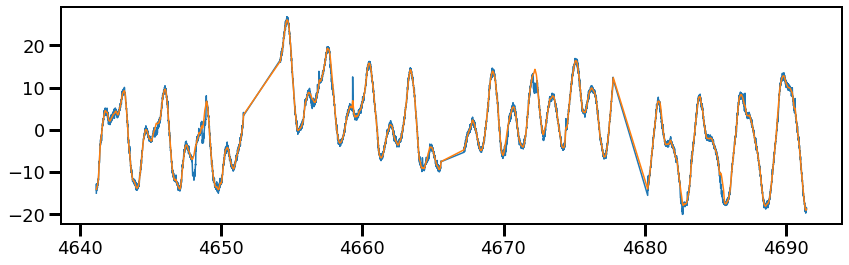

In [43]:
plt.figure(figsize=(14,4))
plt.plot(lc_tab['time'], lc_tab['flux'])
plt.plot(lc_tab['time'], lc_tab['gp_pred_tess'])